# Car Classify

In [47]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
from PIL import Image
import seaborn as sns

## load data
pandas dataframe
dfclass, dftrain, dftest

In [48]:
basedir = './'

# 클래스 데이터 읽기  
dfclass = pd.read_csv(basedir+'class.csv')

In [49]:
dfclass.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


In [50]:
# 테스트 데이터 읽기  
dftest = pd.read_csv(basedir+'test.csv')
dftest.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


In [51]:
# 훈련 데이터 읽기  
dftrain = pd.read_csv(basedir+'train.csv')
dftrain.head()
dftrain['class']=dftrain['class']-1  # make class [0,195] from [1,196]
dftrain.describe()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
count,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,64.450250,108.103103,637.145145,416.097097,98.058358
std,80.943666,106.854930,410.671550,274.215428,56.508850
min,1.000000,1.000000,72.000000,46.000000,0.000000
25%,19.000000,41.000000,390.000000,245.000000,50.000000
50%,39.000000,79.000000,570.000000,361.000000,98.000000
75%,78.000000,137.000000,745.000000,476.000000,147.000000
max,1648.000000,1646.000000,5205.000000,3389.000000,195.000000


In [52]:
# shape 형상, 개수 확인   
dftrain.shape, dftest.shape, dfclass.shape

((9990, 6), (6150, 5), (196, 2))

In [53]:
print(dftrain.count(), dftest.count(), dfclass.count())

img_file    9990
bbox_x1     9990
bbox_y1     9990
bbox_x2     9990
bbox_y2     9990
class       9990
dtype: int64 img_file    6150
bbox_x1     6150
bbox_y1     6150
bbox_x2     6150
bbox_y2     6150
dtype: int64 id      196
name    196
dtype: int64


In [54]:
# 빠진 파일 확인 
for f in dftest.img_file:
    if not os.path.exists(basedir+'test/'+f):
        print('not found:', f)

In [55]:
for f in dftrain.img_file:
    if not os.path.exists(basedir+'train/'+f):
        print('not found:', f)

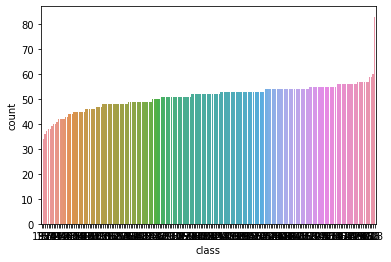

In [56]:
# 클래스별로 개수를 보기. 균일하게 존재하는지 확인.
# 데이터 개수가 학습시 균일할수록 좋다. 한쪽에 너무 치우치면 학습 실패. 
# 마지막에 어떤 클래스의 데이터가 좀 많긴하다. 일단 그대로 학습 진행.. 
sns.countplot(dftrain["class"], order=dftrain["class"].value_counts(ascending=True).index)

In [57]:
# 개수 확인하는 다른 방법. 오름 차순 정렬. 
# dftrain["class"].value_counts(ascending=True)

## image view

(500, 700, 3)
(266, 355, 3)
(194, 259, 3)


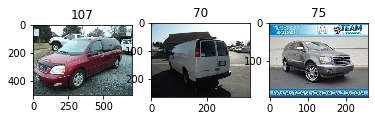

In [58]:
# 이미지 파일 보기 
plt.figure()
pi=0
for i in range(3):
    a = dftrain.img_file[i]
    imgpath = basedir+'train/'+a
    img = plt.imread(imgpath)
    pi+=1
    plt.subplot(1,3,pi)
    plt.title(dftrain["class"][i])
    plt.imshow(img)
    print(img.shape)

train/train_00001.jpg
(224, 224, 3)
train/train_00002.jpg
(224, 224, 3)
train/train_00003.jpg
(224, 224, 3)


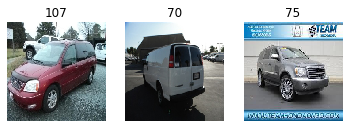

In [59]:
# 크기가 제각각인 이미지. 리사이즈.
# resize??? (224,224,3)

pi=0
for i in range(3):
    a = dftrain.img_file[i]
    imgpath = basedir+'train/'+a
    print(imgpath)
    pi+=1
    plt.subplot(1,3,pi)
    plt.title(dftrain["class"][i])
    plt.axis('off')
    imgobj = Image.open(imgpath)
    imgobj = imgobj.resize((224,224))
    img_r = np.asarray(imgobj)
    plt.imshow(img_r)
    print(img_r.shape)

In [60]:
# 바인딩 박스 정보 확인. test
print(i, img.shape)
print(dftrain.loc[i])
bb = [dftrain.loc[i]['bbox_x1'], dftrain.loc[i]['bbox_y1'], dftrain.loc[i]['bbox_x2'], dftrain.loc[i]['bbox_y2']]
print(bb)

2 (194, 259, 3)
img_file    train_00003.jpg
bbox_x1                  35
bbox_y1                  42
bbox_x2                 227
bbox_y2                 160
class                    75
Name: 2, dtype: object
[35, 42, 227, 160]


## bounding box

In [61]:
# 이미지에 박스 그리기 
def bound(img, x1,y1,x2,y2):
    img[y1,x1:x2] = [255,0,0]
    img[y2,x1:x2] = [255,0,0]
    img[y1:y2,x1] = [255,0,0]
    img[y1:y2,x2] = [255,0,0]
    return img


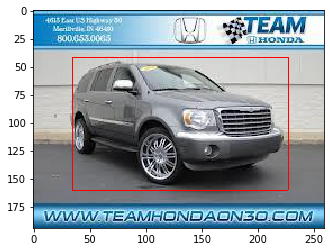

In [62]:
img2 = np.copy(img)
img2=bound(img2, bb[0], bb[1], bb[2], bb[3])
plt.imshow(img2)

In [63]:
# 바인딩 박스가 이미지 리사이즈시 새로운 박스 위치를 찾기
# bb, width, height
def resize_bb(bb, w, h):
    rx = 224/w
    ry = 224/h
    return [int(bb[0]*rx), int(bb[1]*ry), int(bb[2]*rx), int(bb[3]*ry)]

bb2=resize_bb(bb, img.shape[1], img.shape[0])
print(bb, bb2)

[35, 42, 227, 160] [30, 48, 196, 184]


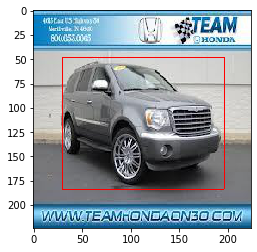

In [64]:
img2 = np.copy(img_r)
img2=bound(img2, bb2[0], bb2[1], bb2[2], bb2[3])
plt.imshow(img2)

## Training dataset preprocessing

image (224,224,3) shape. 3 channels. crop box area.


In [65]:
# 이미지를 바인딩 박스만 추출하여 리사이즈 한다. (차만 보이게 추출하고 리사이즈)
''' crop and resize '''
def prepro_img(imgpath, bb):
    img = Image.open(imgpath)
    img = img.convert('RGB')  # 3 channel image.
#     img = img.convert('L')  # 1 channel gray scale -image.
    imgn = np.asarray(img)
    imgc = imgn[bb[1]:bb[3], bb[0]:bb[2]]
#     print(imgc.shape)
    imgcobj = Image.fromarray(imgc)
    imgcobj2 = imgcobj.resize((224,224))
    newimg = np.asarray(imgcobj2)
    return newimg

(224, 224, 3)


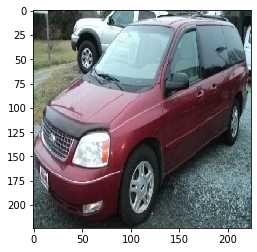

In [66]:
# preprocess test
i=0
imgpath = basedir+'train/'+dftrain.loc[i]['img_file']
bb = [dftrain.loc[i]['bbox_x1'], dftrain.loc[i]['bbox_y1'], dftrain.loc[i]['bbox_x2'], dftrain.loc[i]['bbox_y2']]
cl = dftrain.loc[i]['class']
img = prepro_img(imgpath, bb)
print(img.shape)
plt.imshow(img, cmap='gray')

## Make Train dataset

In [67]:
# 훈련 데이터 만들기. 
#      주의! class값 범위는 0~195로 조정하여 저장. 실제 클래스값(1~196)을 알려면 +1 필요.
# crop and resize하여 저장
# make train data numpy 

force = True

cnt_train = dftrain.shape[0]
x_train=[]
y_train=[]

if not os.path.exists('x_train.npy') or force :
    for i in range(cnt_train):
    # for i in range(100):
        if i%1000==0 :
            print(i, '/', cnt_train)
        imgpath = 'train/'+dftrain.loc[i]['img_file']
        bb = [dftrain.loc[i]['bbox_x1'], dftrain.loc[i]['bbox_y1'], dftrain.loc[i]['bbox_x2'], dftrain.loc[i]['bbox_y2']]
        cl = dftrain.loc[i]['class']
        y_train.append(cl)
        test1 = prepro_img(imgpath, bb)
    #     print(test1.shape)
        x_train.append(test1)
    #     plt.figure()
    #     plt.imshow(test1)
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    ### shuffle
    idx = np.arange(len(x_train))
    np.random.shuffle(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]    
    
    print(x_train.shape, y_train.shape)
    np.save('x_train.npy', x_train)
    np.save('y_train.npy', y_train)
else:
    print('x_train.npy already exsits!')

0 / 9990
1000 / 9990
2000 / 9990
3000 / 9990
4000 / 9990
5000 / 9990
6000 / 9990
7000 / 9990
8000 / 9990
9000 / 9990
(9990, 224, 224, 3) (9990,)


In [68]:
# 테스트 데이터도 전처리하여 저장한다.
# make test data numpy 
cnt_test = dftest.shape[0]
x_test=[]
if not os.path.exists('x_test.npy') or force:
    for i in range(cnt_test):
        if i%1000==0 :
            print(i, '/', cnt_test)
        imgpath = 'test/'+dftest.loc[i]['img_file']
        bb = [dftest.loc[i]['bbox_x1'], dftest.loc[i]['bbox_y1'], dftest.loc[i]['bbox_x2'], dftest.loc[i]['bbox_y2']]
        test1 = prepro_img(imgpath, bb)
        x_test.append(test1)
    x_test = np.asarray(x_test)
    print(x_test.shape)
    np.save('x_test.npy', x_test)
else:
    print('x_test.npy already exsits!')

0 / 6150
1000 / 6150
2000 / 6150
3000 / 6150
4000 / 6150
5000 / 6150
6000 / 6150
(6150, 224, 224, 3)


In [69]:
# release memory 
del dftrain
del dftest
del dfclass
del x_train
del y_train
del x_test